In [1]:
import torch
from torch import nn
import torchvision

import Utils

In [2]:
BATCH_SIZE = 256
IMAGE_CHANNEL = 1
X_DIM = 28
LATENT_DIM = 100
G_HIDDEN = 128
D_HIDDEN = 80
EPOCH_NUM = 250
lr_d = 0.0001
lr_g = 0.0001

In [3]:
device = Utils.get_device()
dataloader = Utils.get_loader(torchvision.datasets.FashionMNIST, X_DIM, BATCH_SIZE)

Using device: cuda
Data loaded


## Sample images from the dataset

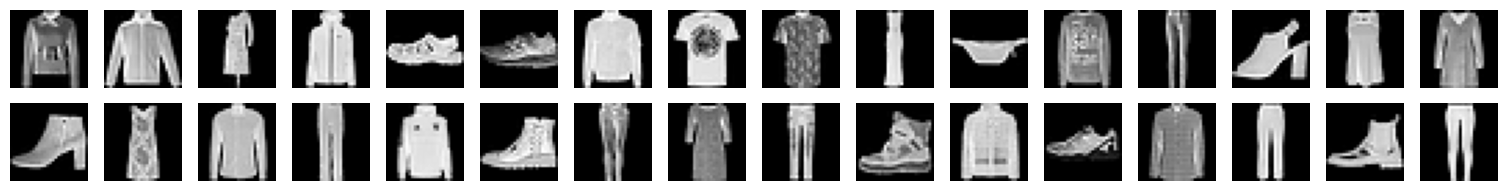

In [4]:
Utils.plot_real(dataloader, X_DIM)

## Model Architecture and Configuration

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(LATENT_DIM, G_HIDDEN * 4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 4, 7, 7)
            # 1nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN * 2, 14, 14)
            # 2rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(inplace=True),  # shape: (G_HIDDEN, 28, 28)
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()  # shape: (IMAGE_CHANNEL, 28, 28)
        )

    def forward(self, x):
        return self.main(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN, 14, 14)
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 2, 7, 7)
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),  # shape: (D_HIDDEN * 4, 3, 3)
            # output layer
            nn.Conv2d(D_HIDDEN * 4, IMAGE_CHANNEL, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # shape: (IMAGE_CHANNEL, 1, 1)
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [8]:
netG = Generator().to(device)
netG.apply(weights_init)
print('Number of parameters in the generator:', Utils.get_n_params(netG))

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of parameters in the discriminator:', Utils.get_n_params(netD))

criterion = nn.BCELoss()
viz_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

Number of parameters in the generator: 5132160
Number of parameters in the discriminator: 1029120


## Training loop

[1/250][150/235]	Loss_D: 0.3237	Loss_G: 1.9369	D(x): 0.8235	D(G(z)): 0.1053 / 0.1736
[2/250][150/235]	Loss_D: 0.3331	Loss_G: 2.0440	D(x): 0.8689	D(G(z)): 0.1605 / 0.1598
[3/250][150/235]	Loss_D: 0.3725	Loss_G: 2.3820	D(x): 0.8504	D(G(z)): 0.1673 / 0.1304
[4/250][150/235]	Loss_D: 0.5028	Loss_G: 1.6735	D(x): 0.7539	D(G(z)): 0.1759 / 0.2221
[5/250][150/235]	Loss_D: 1.0257	Loss_G: 2.4916	D(x): 0.9180	D(G(z)): 0.5619 / 0.1099


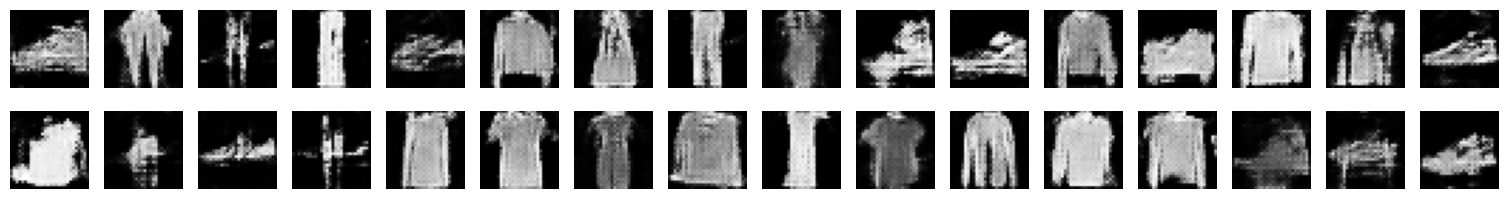

[6/250][150/235]	Loss_D: 0.7166	Loss_G: 2.0235	D(x): 0.8388	D(G(z)): 0.3866 / 0.1607
[7/250][150/235]	Loss_D: 0.5029	Loss_G: 1.7278	D(x): 0.7272	D(G(z)): 0.1450 / 0.2060
[8/250][150/235]	Loss_D: 0.8200	Loss_G: 1.2549	D(x): 0.5129	D(G(z)): 0.0735 / 0.3266
[9/250][150/235]	Loss_D: 0.4521	Loss_G: 2.1845	D(x): 0.8782	D(G(z)): 0.2549 / 0.1357
[10/250][150/235]	Loss_D: 0.4540	Loss_G: 2.1903	D(x): 0.8501	D(G(z)): 0.2373 / 0.1319


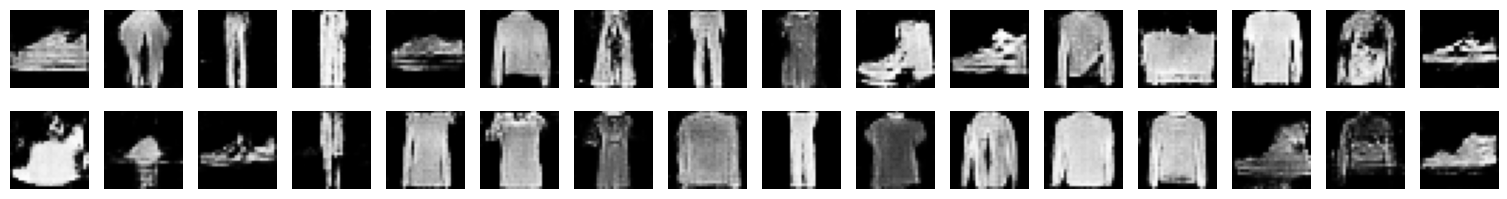

[11/250][150/235]	Loss_D: 0.4737	Loss_G: 1.7971	D(x): 0.8375	D(G(z)): 0.2370 / 0.1981
[12/250][150/235]	Loss_D: 0.5966	Loss_G: 1.3846	D(x): 0.6390	D(G(z)): 0.0990 / 0.2917
[13/250][150/235]	Loss_D: 0.5472	Loss_G: 2.5391	D(x): 0.9195	D(G(z)): 0.3470 / 0.0964
[14/250][150/235]	Loss_D: 0.2858	Loss_G: 2.4357	D(x): 0.8555	D(G(z)): 0.1103 / 0.1096
[15/250][150/235]	Loss_D: 0.6959	Loss_G: 1.3137	D(x): 0.5823	D(G(z)): 0.0719 / 0.3339


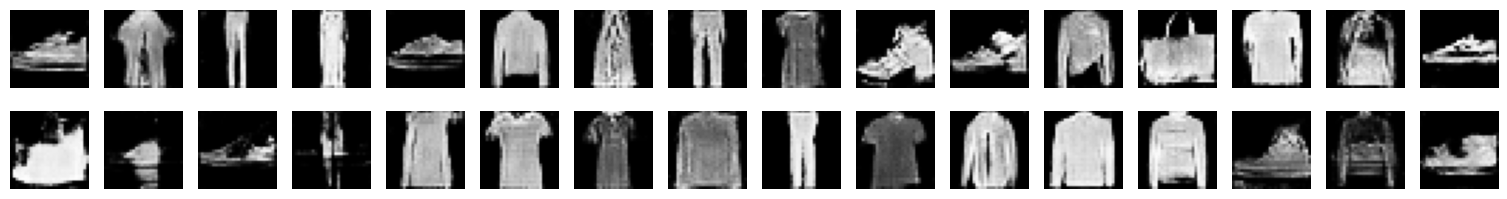

[16/250][150/235]	Loss_D: 0.5494	Loss_G: 2.9877	D(x): 0.9315	D(G(z)): 0.3548 / 0.0646
[17/250][150/235]	Loss_D: 0.3673	Loss_G: 1.9313	D(x): 0.7908	D(G(z)): 0.1048 / 0.1813
[18/250][150/235]	Loss_D: 0.4670	Loss_G: 1.9425	D(x): 0.7693	D(G(z)): 0.1598 / 0.1899
[19/250][150/235]	Loss_D: 0.4247	Loss_G: 2.1453	D(x): 0.8224	D(G(z)): 0.1847 / 0.1489
[20/250][150/235]	Loss_D: 0.6561	Loss_G: 1.8885	D(x): 0.6379	D(G(z)): 0.1369 / 0.2040


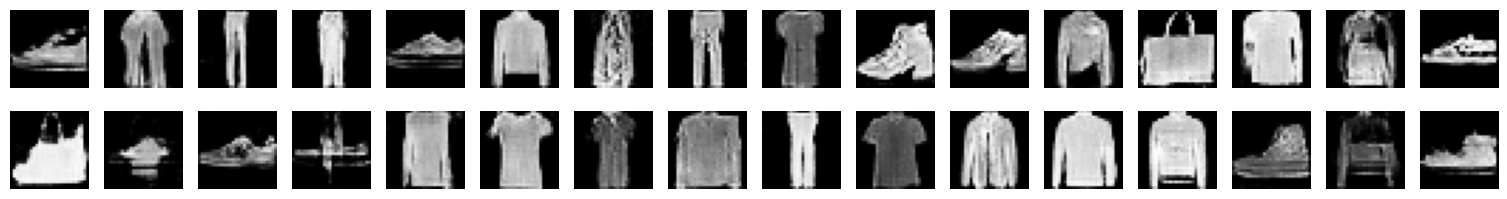

[21/250][150/235]	Loss_D: 0.3542	Loss_G: 2.5150	D(x): 0.8741	D(G(z)): 0.1805 / 0.1019
[22/250][150/235]	Loss_D: 0.4271	Loss_G: 2.5890	D(x): 0.9346	D(G(z)): 0.2719 / 0.1022
[23/250][150/235]	Loss_D: 0.5450	Loss_G: 3.3131	D(x): 0.8949	D(G(z)): 0.3245 / 0.0497
[24/250][150/235]	Loss_D: 0.4383	Loss_G: 2.0099	D(x): 0.7687	D(G(z)): 0.1250 / 0.1870
[25/250][150/235]	Loss_D: 0.2939	Loss_G: 2.2681	D(x): 0.8393	D(G(z)): 0.0952 / 0.1361


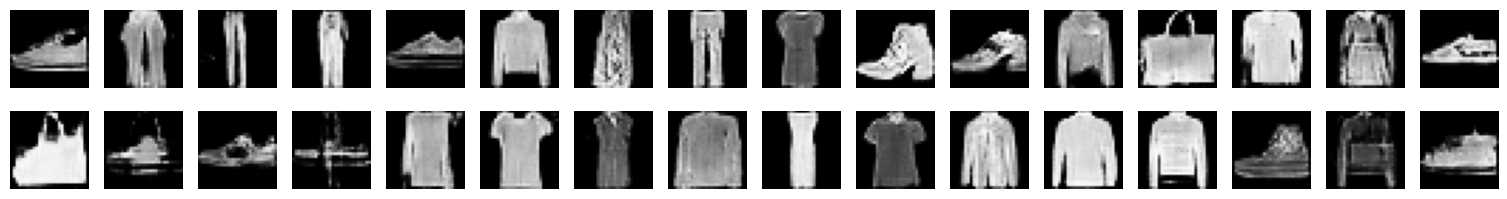

[26/250][150/235]	Loss_D: 0.4410	Loss_G: 1.9758	D(x): 0.7365	D(G(z)): 0.0909 / 0.1829
[27/250][150/235]	Loss_D: 0.3379	Loss_G: 2.3000	D(x): 0.8243	D(G(z)): 0.1165 / 0.1326
[28/250][150/235]	Loss_D: 0.4224	Loss_G: 2.3892	D(x): 0.8752	D(G(z)): 0.2271 / 0.1172
[29/250][150/235]	Loss_D: 0.2874	Loss_G: 2.5605	D(x): 0.8615	D(G(z)): 0.1109 / 0.1127
[30/250][150/235]	Loss_D: 0.5284	Loss_G: 2.3010	D(x): 0.6914	D(G(z)): 0.0888 / 0.1907


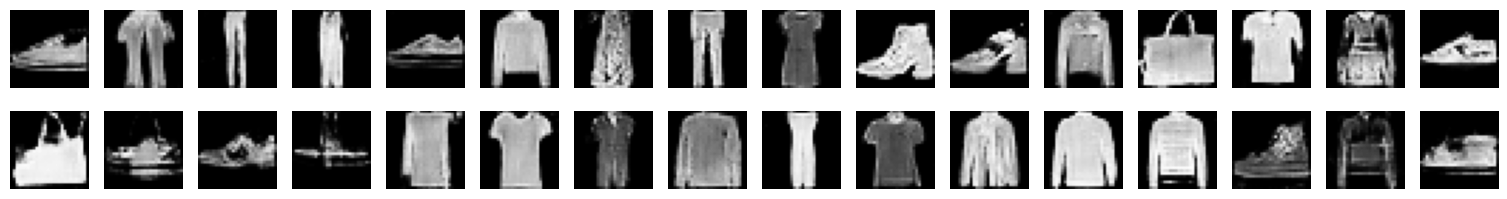

[31/250][150/235]	Loss_D: 0.4803	Loss_G: 2.4411	D(x): 0.8719	D(G(z)): 0.2637 / 0.1164
[32/250][150/235]	Loss_D: 0.3963	Loss_G: 2.2447	D(x): 0.8419	D(G(z)): 0.1765 / 0.1464
[33/250][150/235]	Loss_D: 0.4345	Loss_G: 1.6567	D(x): 0.7624	D(G(z)): 0.1193 / 0.2516
[34/250][150/235]	Loss_D: 0.3832	Loss_G: 3.2878	D(x): 0.9304	D(G(z)): 0.2421 / 0.0522
[35/250][150/235]	Loss_D: 0.2328	Loss_G: 2.8962	D(x): 0.9035	D(G(z)): 0.1135 / 0.0759


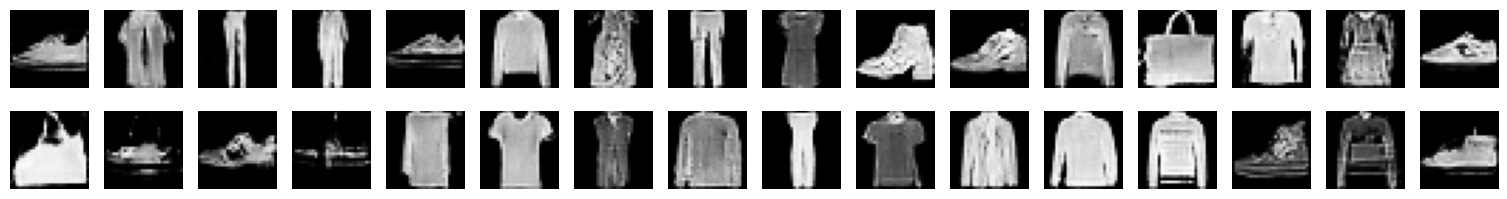

[36/250][150/235]	Loss_D: 0.3357	Loss_G: 2.3678	D(x): 0.7734	D(G(z)): 0.0493 / 0.1286
[37/250][150/235]	Loss_D: 0.2928	Loss_G: 2.6505	D(x): 0.8789	D(G(z)): 0.1324 / 0.1080
[38/250][150/235]	Loss_D: 0.2798	Loss_G: 2.5106	D(x): 0.8410	D(G(z)): 0.0816 / 0.1198
[39/250][150/235]	Loss_D: 0.3251	Loss_G: 2.5731	D(x): 0.8962	D(G(z)): 0.1785 / 0.1028
[40/250][150/235]	Loss_D: 0.2682	Loss_G: 2.8186	D(x): 0.8709	D(G(z)): 0.1055 / 0.0896


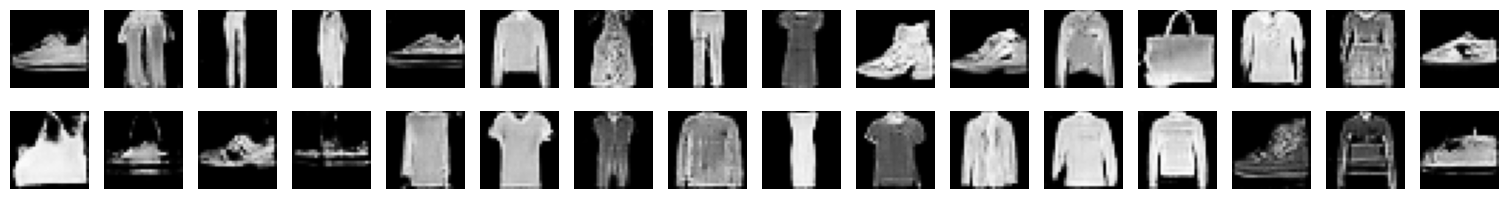

[41/250][150/235]	Loss_D: 0.8182	Loss_G: 1.5756	D(x): 0.5140	D(G(z)): 0.0348 / 0.2842
[42/250][150/235]	Loss_D: 0.2884	Loss_G: 2.1864	D(x): 0.8613	D(G(z)): 0.1155 / 0.1491
[43/250][150/235]	Loss_D: 0.2881	Loss_G: 2.3731	D(x): 0.8466	D(G(z)): 0.1006 / 0.1428
[44/250][150/235]	Loss_D: 0.4019	Loss_G: 2.0422	D(x): 0.7256	D(G(z)): 0.0363 / 0.1863
[45/250][150/235]	Loss_D: 0.2609	Loss_G: 2.6966	D(x): 0.8796	D(G(z)): 0.1098 / 0.0963


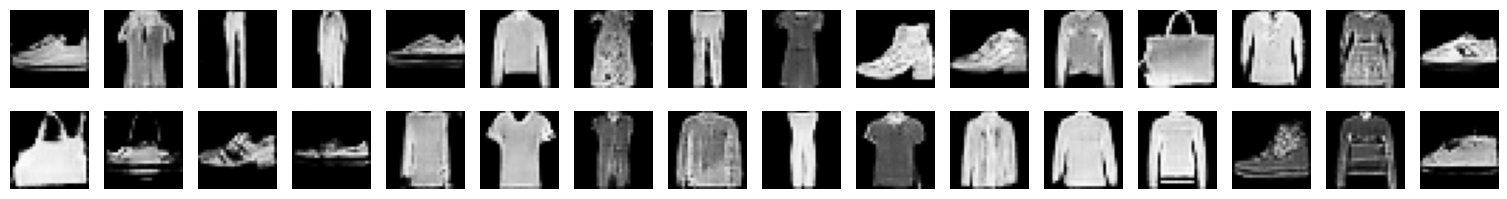

[46/250][150/235]	Loss_D: 0.3232	Loss_G: 2.7570	D(x): 0.8749	D(G(z)): 0.1527 / 0.0939
[47/250][150/235]	Loss_D: 0.3318	Loss_G: 2.6511	D(x): 0.8952	D(G(z)): 0.1771 / 0.1001
[48/250][150/235]	Loss_D: 0.2619	Loss_G: 3.3636	D(x): 0.9301	D(G(z)): 0.1562 / 0.0543
[49/250][150/235]	Loss_D: 0.2423	Loss_G: 3.0274	D(x): 0.8382	D(G(z)): 0.0503 / 0.0771
[50/250][150/235]	Loss_D: 0.2840	Loss_G: 2.9694	D(x): 0.8932	D(G(z)): 0.1409 / 0.0849


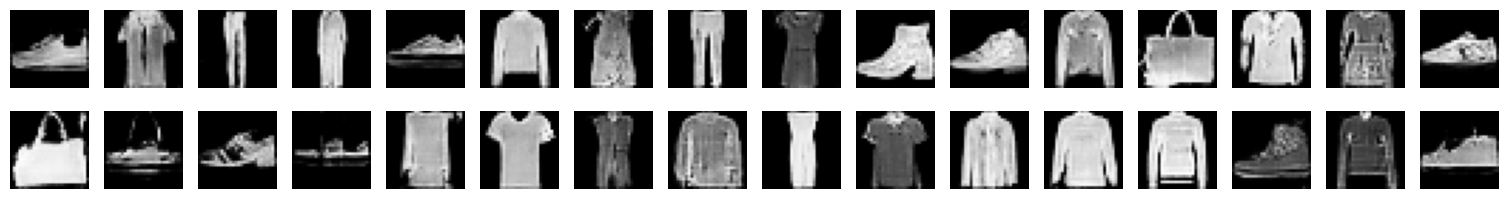

[51/250][150/235]	Loss_D: 0.2366	Loss_G: 2.8368	D(x): 0.8516	D(G(z)): 0.0604 / 0.1000
[52/250][150/235]	Loss_D: 0.2556	Loss_G: 2.7775	D(x): 0.8858	D(G(z)): 0.1127 / 0.0960
[53/250][150/235]	Loss_D: 0.3024	Loss_G: 2.4521	D(x): 0.8536	D(G(z)): 0.1098 / 0.1263
[54/250][150/235]	Loss_D: 0.2818	Loss_G: 3.5350	D(x): 0.9197	D(G(z)): 0.1621 / 0.0457
[55/250][150/235]	Loss_D: 0.2602	Loss_G: 3.0451	D(x): 0.8953	D(G(z)): 0.1215 / 0.0777


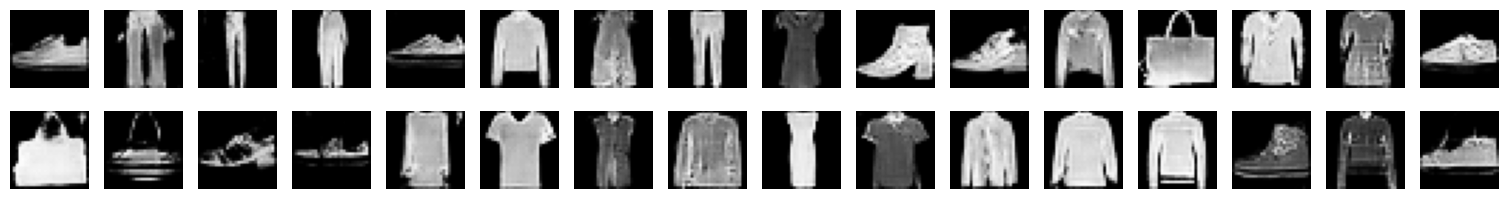

[56/250][150/235]	Loss_D: 0.4586	Loss_G: 2.2596	D(x): 0.7781	D(G(z)): 0.1533 / 0.1751
[57/250][150/235]	Loss_D: 0.2032	Loss_G: 3.0329	D(x): 0.8774	D(G(z)): 0.0624 / 0.0670
[58/250][150/235]	Loss_D: 0.3179	Loss_G: 3.2214	D(x): 0.9159	D(G(z)): 0.1833 / 0.0613
[59/250][150/235]	Loss_D: 0.3108	Loss_G: 2.9593	D(x): 0.8908	D(G(z)): 0.1518 / 0.0807
[60/250][150/235]	Loss_D: 0.2382	Loss_G: 3.5199	D(x): 0.9121	D(G(z)): 0.1226 / 0.0525


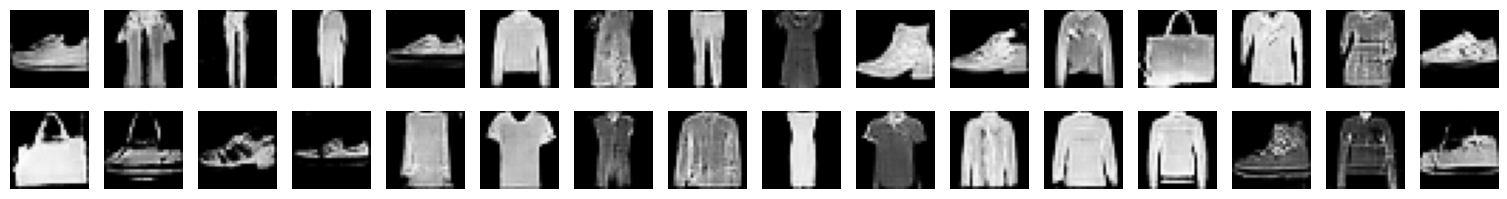

[61/250][150/235]	Loss_D: 0.5787	Loss_G: 2.3709	D(x): 0.6162	D(G(z)): 0.0181 / 0.1481
[62/250][150/235]	Loss_D: 0.2367	Loss_G: 3.0620	D(x): 0.9078	D(G(z)): 0.1142 / 0.0744
[63/250][150/235]	Loss_D: 0.2881	Loss_G: 2.5559	D(x): 0.8050	D(G(z)): 0.0473 / 0.1191
[64/250][150/235]	Loss_D: 0.4752	Loss_G: 4.6548	D(x): 0.9522	D(G(z)): 0.2992 / 0.0194
[65/250][150/235]	Loss_D: 0.3734	Loss_G: 1.5136	D(x): 0.7654	D(G(z)): 0.0680 / 0.2936


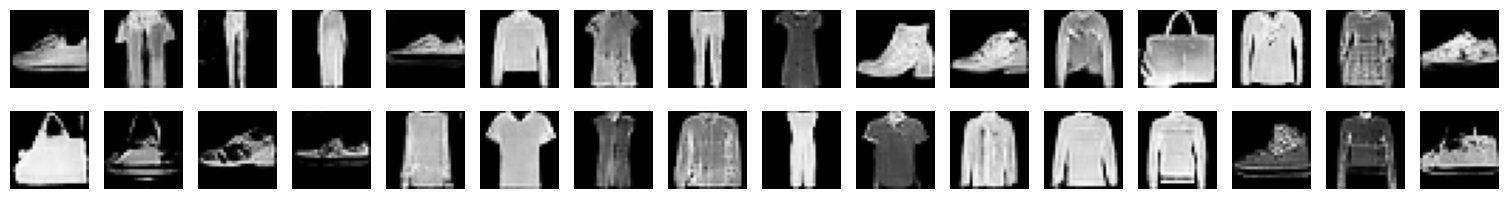

[66/250][150/235]	Loss_D: 0.3767	Loss_G: 2.3666	D(x): 0.7863	D(G(z)): 0.0908 / 0.1667
[67/250][150/235]	Loss_D: 0.2573	Loss_G: 2.8977	D(x): 0.8733	D(G(z)): 0.1009 / 0.0862
[68/250][150/235]	Loss_D: 0.2994	Loss_G: 2.3494	D(x): 0.8335	D(G(z)): 0.0903 / 0.1492
[69/250][150/235]	Loss_D: 0.2136	Loss_G: 2.8510	D(x): 0.9055	D(G(z)): 0.0977 / 0.0878
[70/250][150/235]	Loss_D: 0.3089	Loss_G: 3.8012	D(x): 0.8258	D(G(z)): 0.0407 / 0.0377


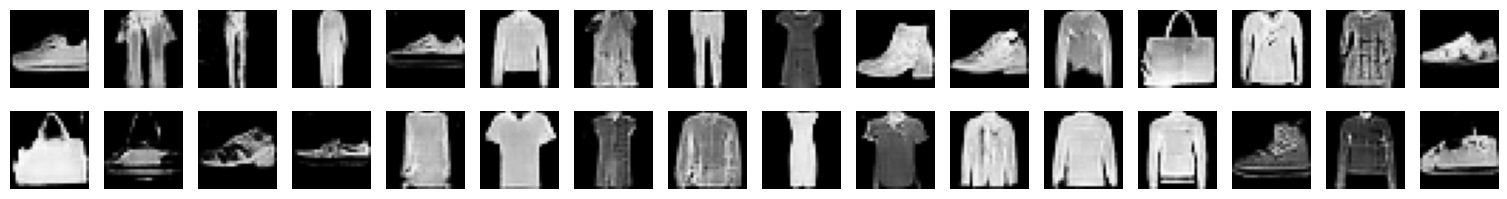

[71/250][150/235]	Loss_D: 0.4375	Loss_G: 2.5602	D(x): 0.7290	D(G(z)): 0.0622 / 0.1332
[72/250][150/235]	Loss_D: 0.2195	Loss_G: 3.3751	D(x): 0.9415	D(G(z)): 0.1348 / 0.0547
[73/250][150/235]	Loss_D: 0.6312	Loss_G: 1.3209	D(x): 0.6226	D(G(z)): 0.0728 / 0.3580
[74/250][150/235]	Loss_D: 0.6886	Loss_G: 4.1174	D(x): 0.9386	D(G(z)): 0.3406 / 0.0638
[75/250][150/235]	Loss_D: 0.2899	Loss_G: 3.2740	D(x): 0.9418	D(G(z)): 0.1853 / 0.0632


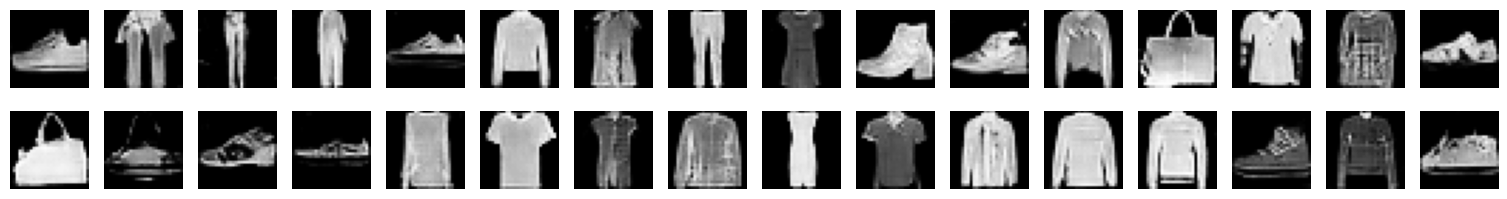

[76/250][150/235]	Loss_D: 0.3053	Loss_G: 2.4320	D(x): 0.8108	D(G(z)): 0.0703 / 0.1276
[77/250][150/235]	Loss_D: 0.2125	Loss_G: 3.0184	D(x): 0.8722	D(G(z)): 0.0589 / 0.0885
[78/250][150/235]	Loss_D: 0.2015	Loss_G: 3.0478	D(x): 0.9009	D(G(z)): 0.0809 / 0.0791
[79/250][150/235]	Loss_D: 0.2510	Loss_G: 2.6355	D(x): 0.8488	D(G(z)): 0.0726 / 0.1099
[80/250][150/235]	Loss_D: 0.6326	Loss_G: 2.0845	D(x): 0.6721	D(G(z)): 0.0987 / 0.2699


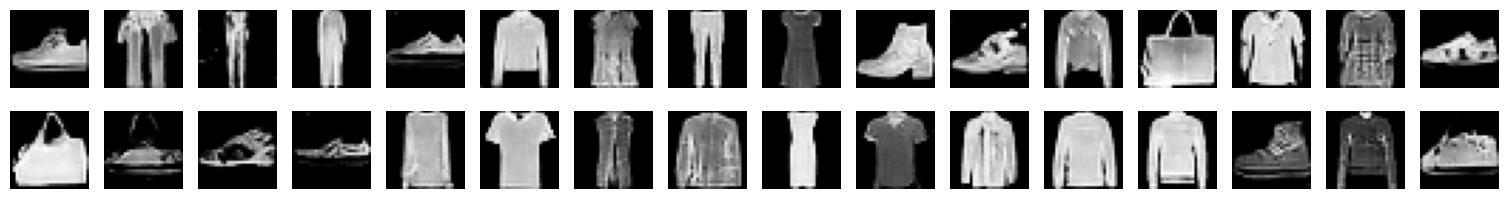

[81/250][150/235]	Loss_D: 0.2032	Loss_G: 3.1274	D(x): 0.8620	D(G(z)): 0.0394 / 0.0729
[82/250][150/235]	Loss_D: 0.2787	Loss_G: 2.8913	D(x): 0.9218	D(G(z)): 0.1626 / 0.0864
[83/250][150/235]	Loss_D: 0.3379	Loss_G: 2.3756	D(x): 0.8162	D(G(z)): 0.1064 / 0.1582
[84/250][150/235]	Loss_D: 0.1899	Loss_G: 2.9628	D(x): 0.8789	D(G(z)): 0.0500 / 0.0874
[85/250][150/235]	Loss_D: 0.3122	Loss_G: 2.1140	D(x): 0.8588	D(G(z)): 0.1268 / 0.1832


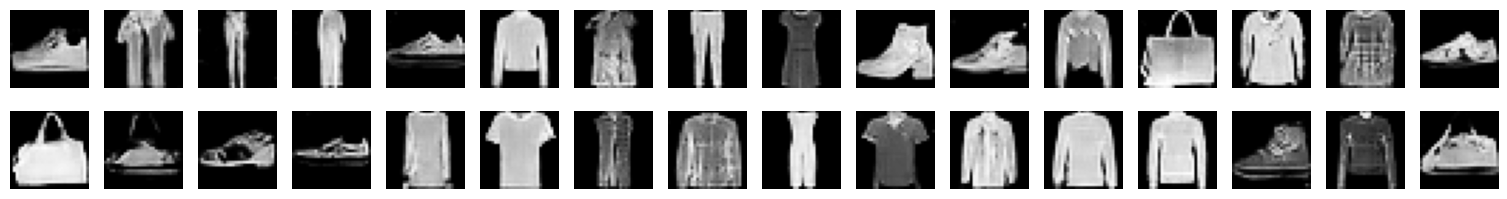

[86/250][150/235]	Loss_D: 0.2986	Loss_G: 2.9932	D(x): 0.8059	D(G(z)): 0.0456 / 0.1185
[87/250][150/235]	Loss_D: 0.2587	Loss_G: 3.2630	D(x): 0.9433	D(G(z)): 0.1634 / 0.0612
[88/250][150/235]	Loss_D: 0.2957	Loss_G: 3.7194	D(x): 0.9376	D(G(z)): 0.1756 / 0.0408
[89/250][150/235]	Loss_D: 0.1925	Loss_G: 3.0142	D(x): 0.8749	D(G(z)): 0.0483 / 0.0820
[90/250][150/235]	Loss_D: 0.2713	Loss_G: 3.0032	D(x): 0.8035	D(G(z)): 0.0313 / 0.0777


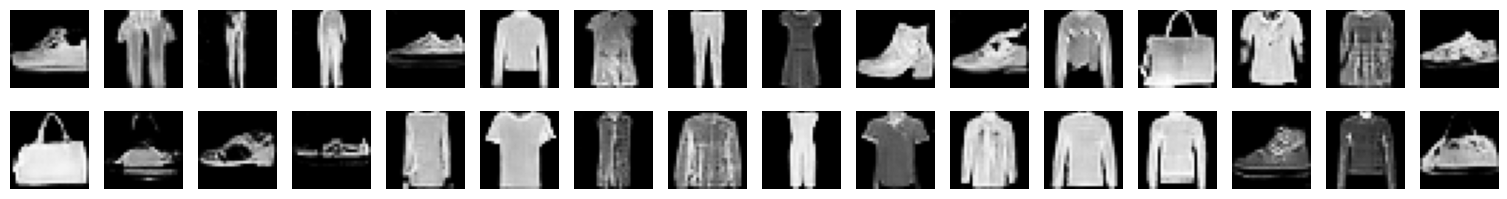

[91/250][150/235]	Loss_D: 0.2457	Loss_G: 4.1605	D(x): 0.8048	D(G(z)): 0.0087 / 0.0385
[92/250][150/235]	Loss_D: 0.1759	Loss_G: 3.2129	D(x): 0.9369	D(G(z)): 0.0965 / 0.0718
[93/250][150/235]	Loss_D: 0.1778	Loss_G: 3.4899	D(x): 0.9378	D(G(z)): 0.1004 / 0.0492
[94/250][150/235]	Loss_D: 0.2370	Loss_G: 3.2322	D(x): 0.8672	D(G(z)): 0.0663 / 0.0721
[95/250][150/235]	Loss_D: 0.1984	Loss_G: 2.9202	D(x): 0.8632	D(G(z)): 0.0405 / 0.0934


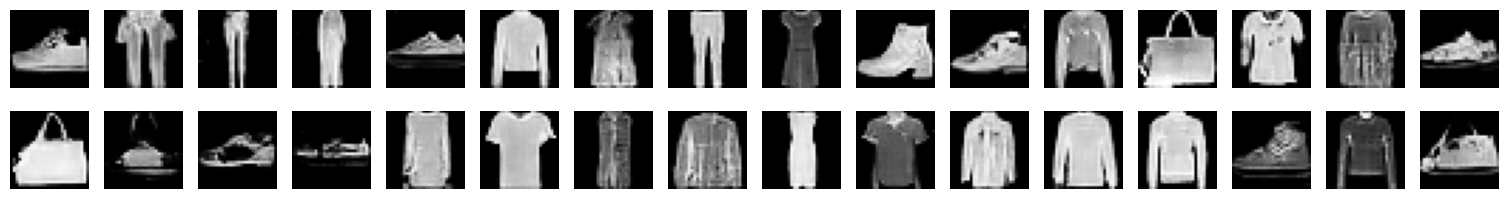

[96/250][150/235]	Loss_D: 0.2738	Loss_G: 4.2018	D(x): 0.9461	D(G(z)): 0.1789 / 0.0293
[97/250][150/235]	Loss_D: 0.1725	Loss_G: 3.3958	D(x): 0.9187	D(G(z)): 0.0769 / 0.0555
[98/250][150/235]	Loss_D: 0.1932	Loss_G: 3.4705	D(x): 0.9419	D(G(z)): 0.1132 / 0.0504
[99/250][150/235]	Loss_D: 0.1780	Loss_G: 3.4929	D(x): 0.9334	D(G(z)): 0.0925 / 0.0530
[100/250][150/235]	Loss_D: 0.4839	Loss_G: 4.9964	D(x): 0.9303	D(G(z)): 0.2717 / 0.0238


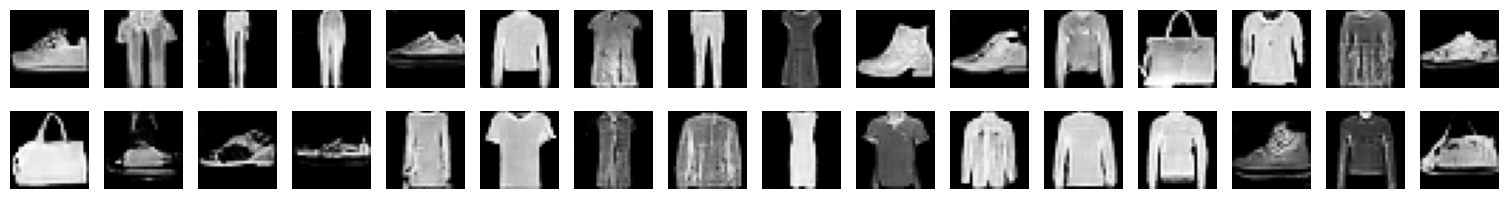

[101/250][150/235]	Loss_D: 0.3748	Loss_G: 2.2946	D(x): 0.7474	D(G(z)): 0.0521 / 0.1541
[102/250][150/235]	Loss_D: 0.5269	Loss_G: 2.3125	D(x): 0.7192	D(G(z)): 0.0744 / 0.1953
[103/250][150/235]	Loss_D: 0.1680	Loss_G: 3.1450	D(x): 0.9348	D(G(z)): 0.0876 / 0.0725
[104/250][150/235]	Loss_D: 0.2645	Loss_G: 4.1605	D(x): 0.9699	D(G(z)): 0.1858 / 0.0250
[105/250][150/235]	Loss_D: 0.4475	Loss_G: 3.3582	D(x): 0.9212	D(G(z)): 0.2589 / 0.0679


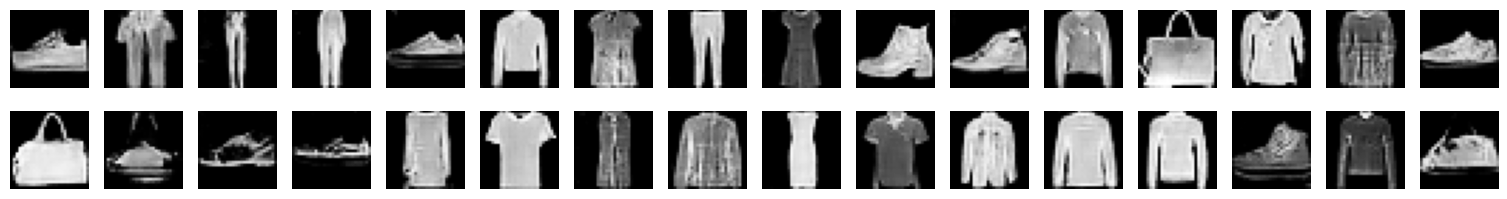

[106/250][150/235]	Loss_D: 0.1789	Loss_G: 3.4613	D(x): 0.8932	D(G(z)): 0.0556 / 0.0606
[107/250][150/235]	Loss_D: 0.2221	Loss_G: 3.1293	D(x): 0.9056	D(G(z)): 0.0909 / 0.0759
[108/250][150/235]	Loss_D: 0.1389	Loss_G: 3.9520	D(x): 0.9178	D(G(z)): 0.0424 / 0.0378
[109/250][150/235]	Loss_D: 0.2332	Loss_G: 3.0209	D(x): 0.8808	D(G(z)): 0.0858 / 0.0935
[110/250][150/235]	Loss_D: 0.2569	Loss_G: 3.4214	D(x): 0.8881	D(G(z)): 0.1122 / 0.0575


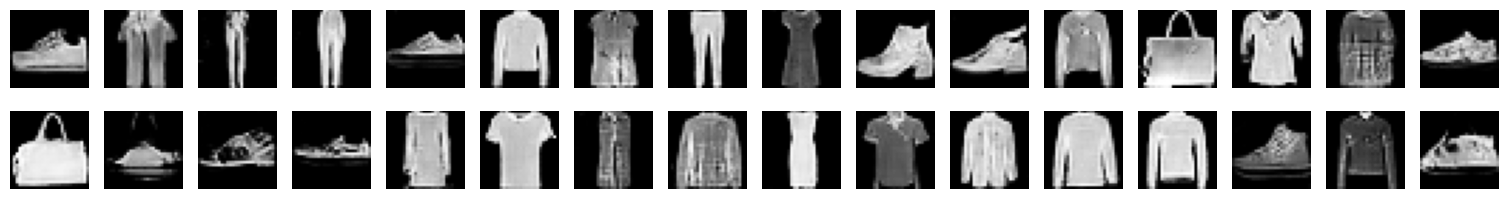

[111/250][150/235]	Loss_D: 0.2600	Loss_G: 3.9077	D(x): 0.9318	D(G(z)): 0.1507 / 0.0394
[112/250][150/235]	Loss_D: 0.1598	Loss_G: 3.7077	D(x): 0.9508	D(G(z)): 0.0942 / 0.0402
[113/250][150/235]	Loss_D: 0.2051	Loss_G: 3.4410	D(x): 0.8874	D(G(z)): 0.0722 / 0.0520
[114/250][150/235]	Loss_D: 0.1428	Loss_G: 4.0719	D(x): 0.9464	D(G(z)): 0.0770 / 0.0326
[115/250][150/235]	Loss_D: 0.3579	Loss_G: 2.8539	D(x): 0.8400	D(G(z)): 0.1316 / 0.1186


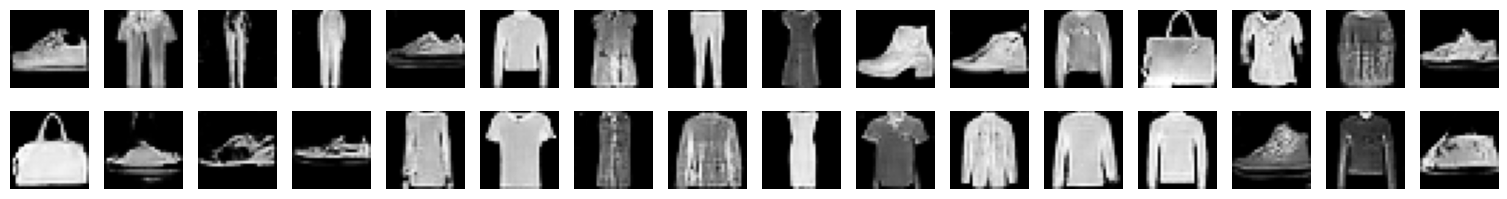

[116/250][150/235]	Loss_D: 0.2441	Loss_G: 3.6770	D(x): 0.9247	D(G(z)): 0.1342 / 0.0448
[117/250][150/235]	Loss_D: 0.2070	Loss_G: 3.4124	D(x): 0.9251	D(G(z)): 0.1112 / 0.0551
[118/250][150/235]	Loss_D: 0.3512	Loss_G: 2.8431	D(x): 0.9225	D(G(z)): 0.1891 / 0.1126
[119/250][150/235]	Loss_D: 0.1914	Loss_G: 3.4381	D(x): 0.8879	D(G(z)): 0.0596 / 0.0543
[120/250][150/235]	Loss_D: 0.2249	Loss_G: 3.2428	D(x): 0.8581	D(G(z)): 0.0556 / 0.0759


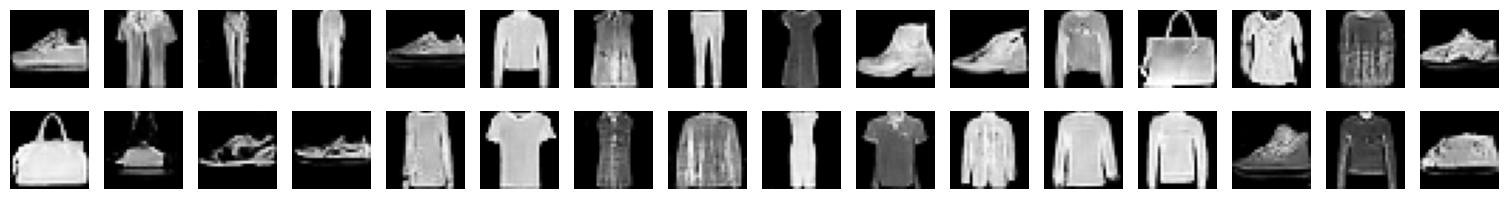

[121/250][150/235]	Loss_D: 0.7174	Loss_G: 1.8999	D(x): 0.6029	D(G(z)): 0.0544 / 0.3003
[122/250][150/235]	Loss_D: 0.1383	Loss_G: 3.1027	D(x): 0.9342	D(G(z)): 0.0617 / 0.0758
[123/250][150/235]	Loss_D: 0.2143	Loss_G: 3.7059	D(x): 0.9298	D(G(z)): 0.1128 / 0.0463
[124/250][150/235]	Loss_D: 0.3311	Loss_G: 4.0789	D(x): 0.9676	D(G(z)): 0.2240 / 0.0332
[125/250][150/235]	Loss_D: 0.2117	Loss_G: 4.0060	D(x): 0.9413	D(G(z)): 0.1260 / 0.0362


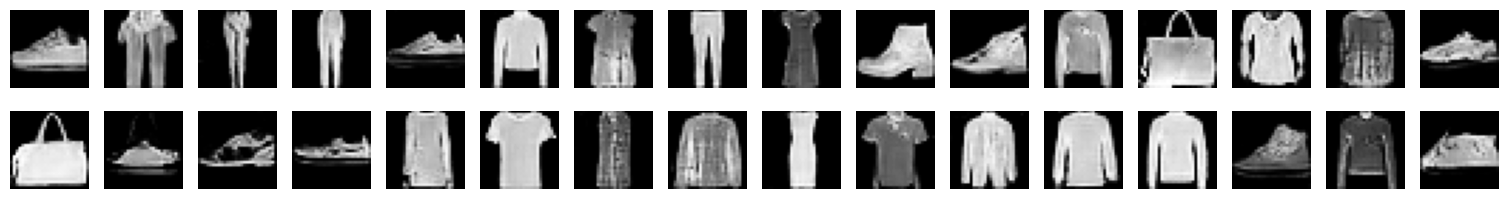

[126/250][150/235]	Loss_D: 0.2459	Loss_G: 2.4134	D(x): 0.8523	D(G(z)): 0.0663 / 0.1547
[127/250][150/235]	Loss_D: 0.6623	Loss_G: 1.5624	D(x): 0.6201	D(G(z)): 0.0802 / 0.3424
[128/250][150/235]	Loss_D: 0.2448	Loss_G: 2.3956	D(x): 0.8845	D(G(z)): 0.0970 / 0.1495
[129/250][150/235]	Loss_D: 0.1642	Loss_G: 3.5900	D(x): 0.8914	D(G(z)): 0.0361 / 0.0504
[130/250][150/235]	Loss_D: 0.3540	Loss_G: 3.6049	D(x): 0.9515	D(G(z)): 0.2294 / 0.0433


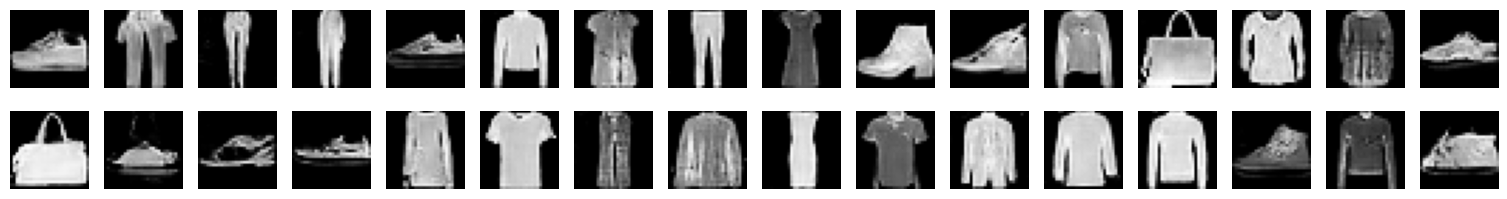

[131/250][150/235]	Loss_D: 0.1609	Loss_G: 3.7426	D(x): 0.9016	D(G(z)): 0.0465 / 0.0512
[132/250][150/235]	Loss_D: 0.1953	Loss_G: 3.5018	D(x): 0.9348	D(G(z)): 0.1055 / 0.0589
[133/250][150/235]	Loss_D: 0.2418	Loss_G: 2.5389	D(x): 0.8498	D(G(z)): 0.0612 / 0.1371
[134/250][150/235]	Loss_D: 0.1548	Loss_G: 3.6898	D(x): 0.9343	D(G(z)): 0.0750 / 0.0493
[135/250][150/235]	Loss_D: 0.5228	Loss_G: 3.5130	D(x): 0.8834	D(G(z)): 0.2760 / 0.0479


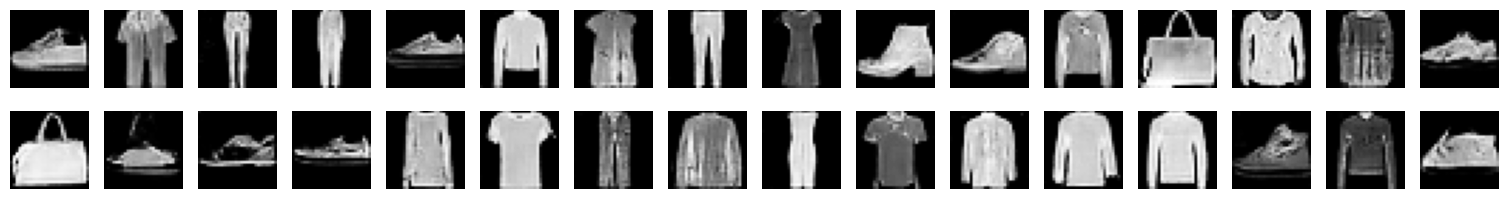

[136/250][150/235]	Loss_D: 0.3720	Loss_G: 4.0910	D(x): 0.9030	D(G(z)): 0.2008 / 0.0313
[137/250][150/235]	Loss_D: 0.2089	Loss_G: 4.0043	D(x): 0.8611	D(G(z)): 0.0371 / 0.0372
[138/250][150/235]	Loss_D: 0.2128	Loss_G: 3.8942	D(x): 0.9373	D(G(z)): 0.1213 / 0.0381
[139/250][150/235]	Loss_D: 0.3247	Loss_G: 2.7364	D(x): 0.7961	D(G(z)): 0.0632 / 0.1138
[140/250][150/235]	Loss_D: 0.2259	Loss_G: 3.6274	D(x): 0.9175	D(G(z)): 0.1147 / 0.0510


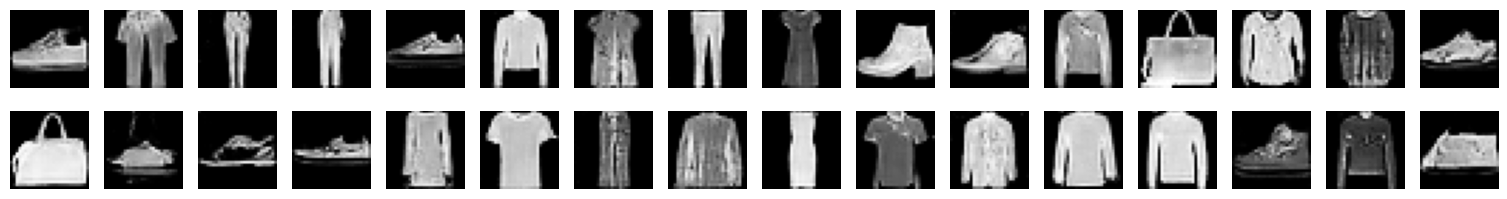

[141/250][150/235]	Loss_D: 0.2495	Loss_G: 4.5231	D(x): 0.9884	D(G(z)): 0.1707 / 0.0223
[142/250][150/235]	Loss_D: 0.2574	Loss_G: 3.3636	D(x): 0.9377	D(G(z)): 0.1542 / 0.0604
[143/250][150/235]	Loss_D: 0.1620	Loss_G: 2.7066	D(x): 0.8967	D(G(z)): 0.0424 / 0.1332
[144/250][150/235]	Loss_D: 1.7245	Loss_G: 6.3179	D(x): 0.9851	D(G(z)): 0.6900 / 0.0053
[145/250][150/235]	Loss_D: 0.2151	Loss_G: 3.6245	D(x): 0.9172	D(G(z)): 0.1085 / 0.0483


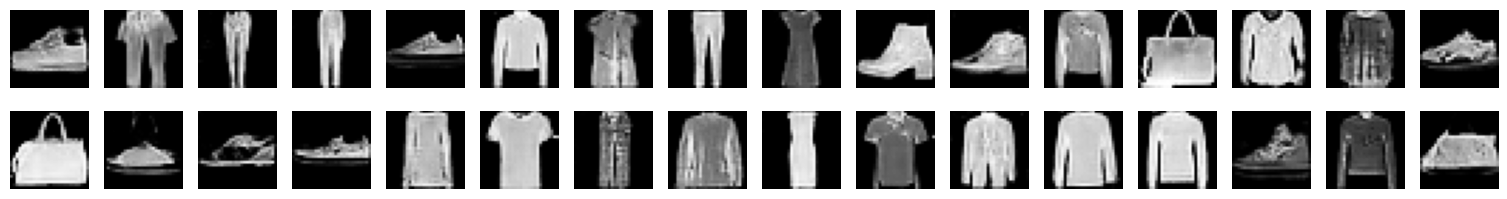

[146/250][150/235]	Loss_D: 0.2730	Loss_G: 3.1177	D(x): 0.8287	D(G(z)): 0.0569 / 0.0889
[147/250][150/235]	Loss_D: 0.3673	Loss_G: 4.5284	D(x): 0.9790	D(G(z)): 0.2453 / 0.0214
[148/250][150/235]	Loss_D: 0.1364	Loss_G: 3.4836	D(x): 0.9119	D(G(z)): 0.0371 / 0.0567
[149/250][150/235]	Loss_D: 0.4238	Loss_G: 2.3985	D(x): 0.7040	D(G(z)): 0.0203 / 0.1644
[150/250][150/235]	Loss_D: 0.1882	Loss_G: 3.5194	D(x): 0.9438	D(G(z)): 0.1060 / 0.0538


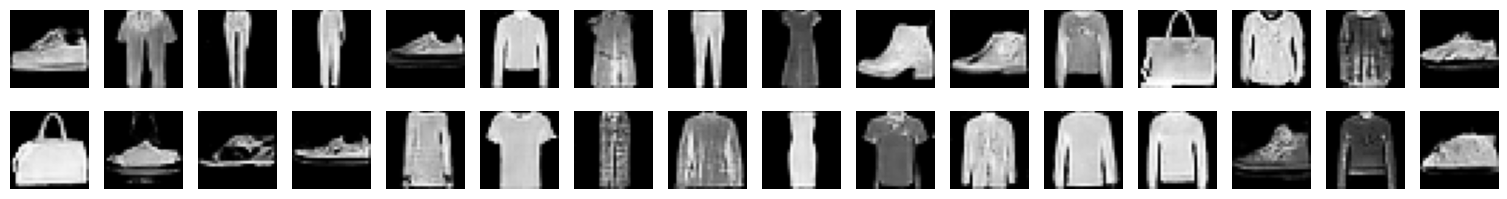

[151/250][150/235]	Loss_D: 0.1500	Loss_G: 3.1860	D(x): 0.9099	D(G(z)): 0.0478 / 0.0747
[152/250][150/235]	Loss_D: 0.1308	Loss_G: 3.7326	D(x): 0.9219	D(G(z)): 0.0426 / 0.0450
[153/250][150/235]	Loss_D: 0.2852	Loss_G: 2.7029	D(x): 0.8564	D(G(z)): 0.0968 / 0.1080
[154/250][150/235]	Loss_D: 0.4100	Loss_G: 3.5061	D(x): 0.8023	D(G(z)): 0.1150 / 0.0637
[155/250][150/235]	Loss_D: 0.2980	Loss_G: 3.5739	D(x): 0.9169	D(G(z)): 0.1611 / 0.0468


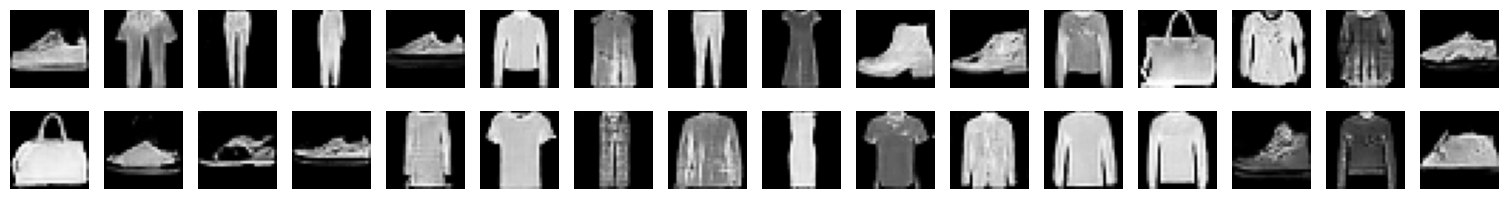

[156/250][150/235]	Loss_D: 0.1912	Loss_G: 3.4314	D(x): 0.8603	D(G(z)): 0.0294 / 0.0712
[157/250][150/235]	Loss_D: 0.7538	Loss_G: 3.5286	D(x): 0.7424	D(G(z)): 0.1954 / 0.2230
[158/250][150/235]	Loss_D: 0.1812	Loss_G: 3.0778	D(x): 0.9162	D(G(z)): 0.0785 / 0.0827
[159/250][150/235]	Loss_D: 0.3377	Loss_G: 2.9213	D(x): 0.7957	D(G(z)): 0.0773 / 0.1026
[160/250][150/235]	Loss_D: 0.3174	Loss_G: 2.7820	D(x): 0.8297	D(G(z)): 0.0889 / 0.1109


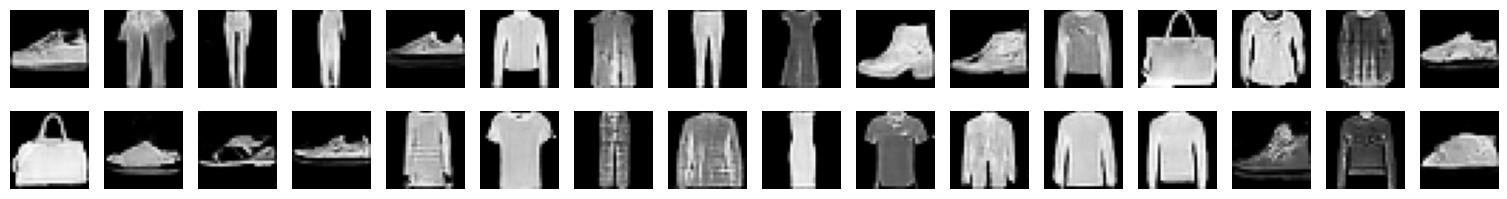

[161/250][150/235]	Loss_D: 0.1478	Loss_G: 3.7924	D(x): 0.9105	D(G(z)): 0.0458 / 0.0438
[162/250][150/235]	Loss_D: 0.0998	Loss_G: 3.6298	D(x): 0.9633	D(G(z)): 0.0564 / 0.0532
[163/250][150/235]	Loss_D: 1.0103	Loss_G: 1.0812	D(x): 0.5623	D(G(z)): 0.1937 / 0.4227
[164/250][150/235]	Loss_D: 0.6010	Loss_G: 4.6360	D(x): 0.9741	D(G(z)): 0.3464 / 0.0348
[165/250][150/235]	Loss_D: 0.2525	Loss_G: 3.8646	D(x): 0.9571	D(G(z)): 0.1614 / 0.0413


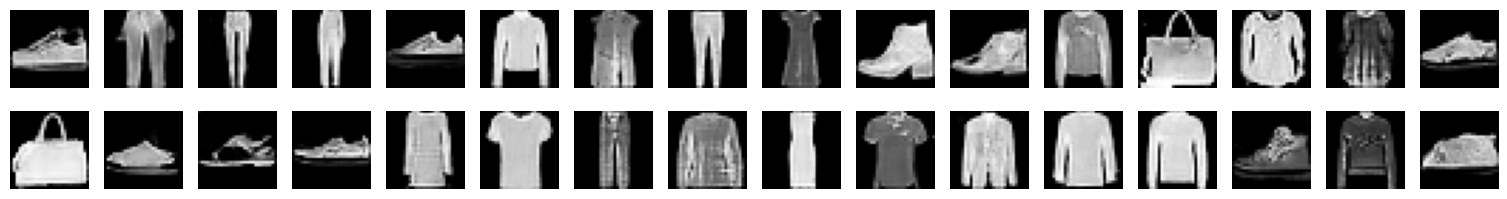

[166/250][150/235]	Loss_D: 0.2094	Loss_G: 3.6148	D(x): 0.8918	D(G(z)): 0.0765 / 0.0518
[167/250][150/235]	Loss_D: 0.1794	Loss_G: 3.8372	D(x): 0.9745	D(G(z)): 0.1285 / 0.0401
[168/250][150/235]	Loss_D: 0.1485	Loss_G: 3.8940	D(x): 0.9560	D(G(z)): 0.0887 / 0.0437
[169/250][150/235]	Loss_D: 0.1457	Loss_G: 3.9478	D(x): 0.9456	D(G(z)): 0.0783 / 0.0379
[170/250][150/235]	Loss_D: 0.2612	Loss_G: 2.9336	D(x): 0.8077	D(G(z)): 0.0267 / 0.0988


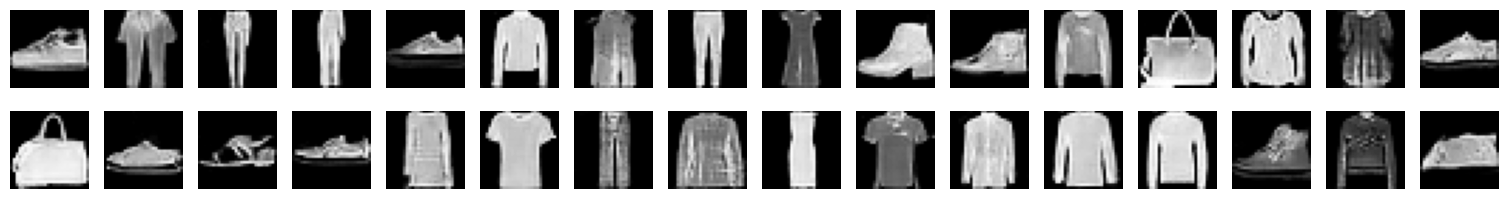

[171/250][150/235]	Loss_D: 0.8182	Loss_G: 5.7171	D(x): 0.9802	D(G(z)): 0.4462 / 0.0113
[172/250][150/235]	Loss_D: 0.3059	Loss_G: 3.0842	D(x): 0.7790	D(G(z)): 0.0276 / 0.0908
[173/250][150/235]	Loss_D: 0.1446	Loss_G: 3.2712	D(x): 0.9218	D(G(z)): 0.0544 / 0.0722
[174/250][150/235]	Loss_D: 0.1086	Loss_G: 4.1281	D(x): 0.9555	D(G(z)): 0.0569 / 0.0331
[175/250][150/235]	Loss_D: 0.2529	Loss_G: 3.3540	D(x): 0.8269	D(G(z)): 0.0414 / 0.0724


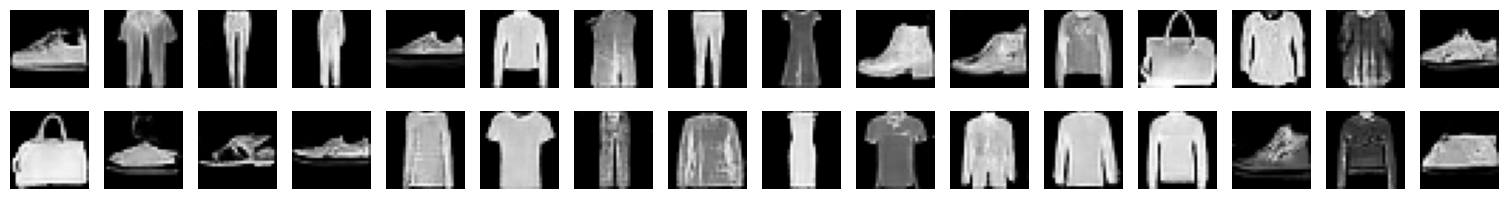

[176/250][150/235]	Loss_D: 0.1814	Loss_G: 3.5612	D(x): 0.9515	D(G(z)): 0.1088 / 0.0590
[177/250][150/235]	Loss_D: 0.3251	Loss_G: 3.3245	D(x): 0.9333	D(G(z)): 0.1892 / 0.0706
[178/250][150/235]	Loss_D: 0.2026	Loss_G: 3.7349	D(x): 0.8810	D(G(z)): 0.0579 / 0.0495
[179/250][150/235]	Loss_D: 0.2614	Loss_G: 3.4966	D(x): 0.9283	D(G(z)): 0.1453 / 0.0606
[180/250][150/235]	Loss_D: 0.1970	Loss_G: 4.2730	D(x): 0.9257	D(G(z)): 0.0959 / 0.0287


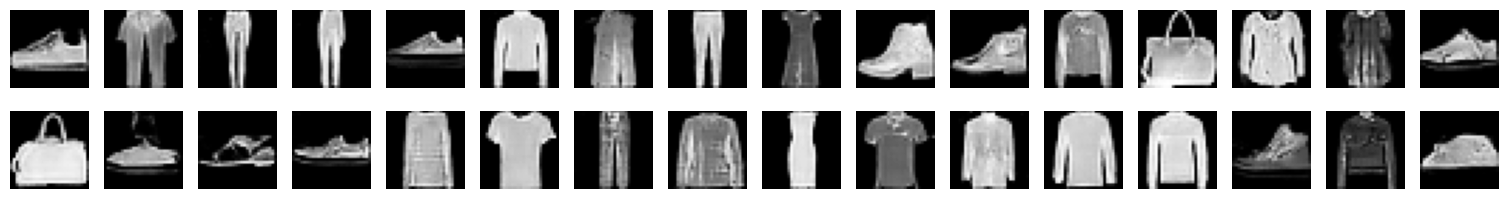

[181/250][150/235]	Loss_D: 0.1125	Loss_G: 4.2458	D(x): 0.9564	D(G(z)): 0.0599 / 0.0317
[182/250][150/235]	Loss_D: 0.2400	Loss_G: 4.4810	D(x): 0.9509	D(G(z)): 0.1518 / 0.0243
[183/250][150/235]	Loss_D: 0.2316	Loss_G: 2.9281	D(x): 0.8431	D(G(z)): 0.0421 / 0.1173
[184/250][150/235]	Loss_D: 0.1954	Loss_G: 3.8338	D(x): 0.8895	D(G(z)): 0.0622 / 0.0498
[185/250][150/235]	Loss_D: 0.2812	Loss_G: 4.1186	D(x): 0.9579	D(G(z)): 0.1821 / 0.0312


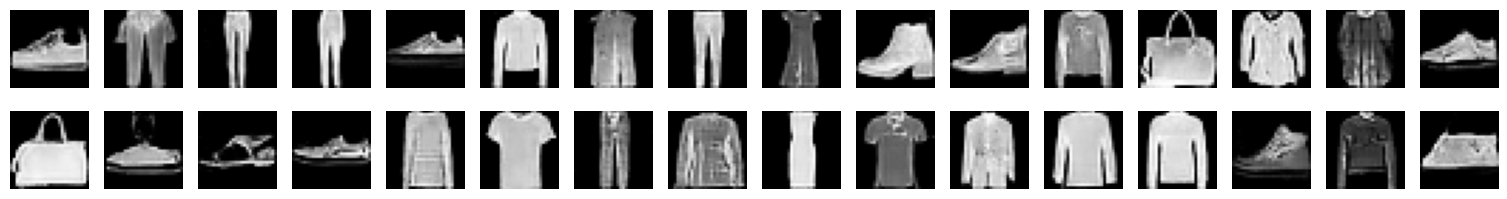

[186/250][150/235]	Loss_D: 0.4268	Loss_G: 3.3718	D(x): 0.8167	D(G(z)): 0.1242 / 0.0850
[187/250][150/235]	Loss_D: 0.1697	Loss_G: 4.1732	D(x): 0.8759	D(G(z)): 0.0269 / 0.0363
[188/250][150/235]	Loss_D: 3.0204	Loss_G: 0.2596	D(x): 0.1374	D(G(z)): 0.0192 / 0.8144
[189/250][150/235]	Loss_D: 0.2834	Loss_G: 3.4055	D(x): 0.7946	D(G(z)): 0.0263 / 0.0854
[190/250][150/235]	Loss_D: 0.1129	Loss_G: 4.2670	D(x): 0.9291	D(G(z)): 0.0325 / 0.0355


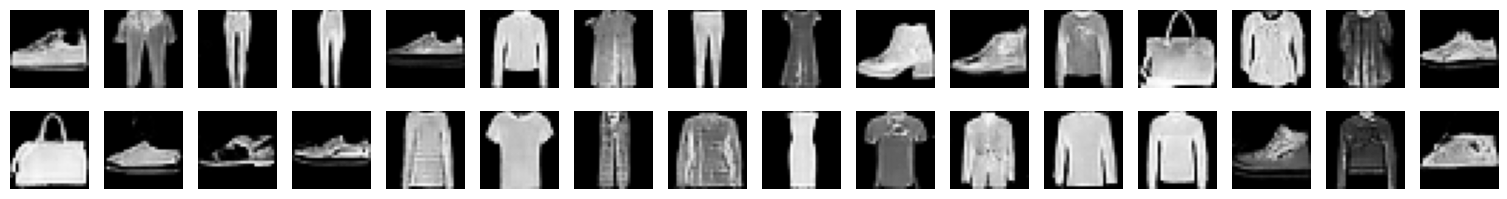

[191/250][150/235]	Loss_D: 0.5683	Loss_G: 2.6965	D(x): 0.7537	D(G(z)): 0.1372 / 0.1976
[192/250][150/235]	Loss_D: 0.3171	Loss_G: 4.8920	D(x): 0.9756	D(G(z)): 0.2072 / 0.0195
[193/250][150/235]	Loss_D: 0.6956	Loss_G: 1.1120	D(x): 0.6349	D(G(z)): 0.1296 / 0.4374
[194/250][150/235]	Loss_D: 0.1320	Loss_G: 4.0086	D(x): 0.9407	D(G(z)): 0.0601 / 0.0384
[195/250][150/235]	Loss_D: 0.1426	Loss_G: 4.2231	D(x): 0.9688	D(G(z)): 0.0957 / 0.0315


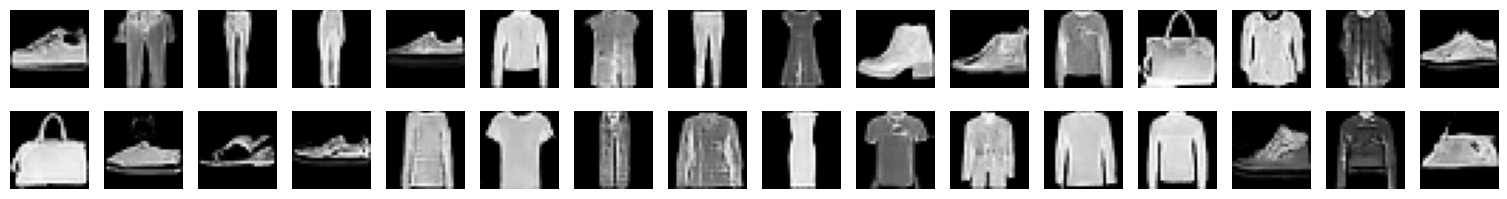

[196/250][150/235]	Loss_D: 0.3303	Loss_G: 4.8178	D(x): 0.9735	D(G(z)): 0.2243 / 0.0174
[197/250][150/235]	Loss_D: 0.2847	Loss_G: 3.4236	D(x): 0.8029	D(G(z)): 0.0340 / 0.0824
[198/250][150/235]	Loss_D: 0.2725	Loss_G: 2.9523	D(x): 0.8388	D(G(z)): 0.0625 / 0.1266
[199/250][150/235]	Loss_D: 0.5553	Loss_G: 5.9206	D(x): 0.9735	D(G(z)): 0.3428 / 0.0148
[200/250][150/235]	Loss_D: 0.1545	Loss_G: 4.3585	D(x): 0.8778	D(G(z)): 0.0129 / 0.0308


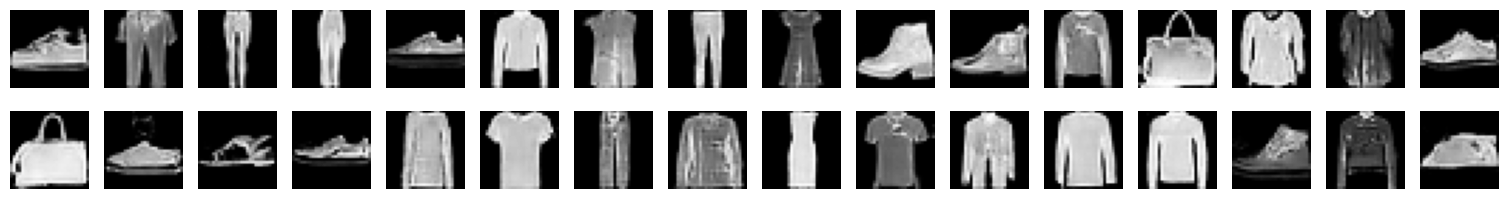

[201/250][150/235]	Loss_D: 0.1340	Loss_G: 3.5337	D(x): 0.9327	D(G(z)): 0.0568 / 0.0506
[202/250][150/235]	Loss_D: 0.1805	Loss_G: 4.0605	D(x): 0.9250	D(G(z)): 0.0814 / 0.0441
[203/250][150/235]	Loss_D: 0.1586	Loss_G: 3.9095	D(x): 0.9060	D(G(z)): 0.0512 / 0.0503
[204/250][150/235]	Loss_D: 0.1475	Loss_G: 3.6862	D(x): 0.9383	D(G(z)): 0.0716 / 0.0563
[205/250][150/235]	Loss_D: 0.1912	Loss_G: 3.9287	D(x): 0.9017	D(G(z)): 0.0659 / 0.0438


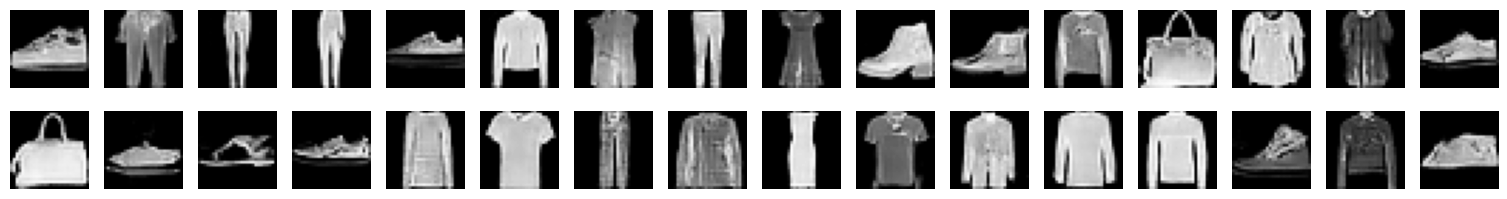

[206/250][150/235]	Loss_D: 0.1038	Loss_G: 4.4105	D(x): 0.9288	D(G(z)): 0.0240 / 0.0310
[207/250][150/235]	Loss_D: 1.4613	Loss_G: 1.4361	D(x): 0.3781	D(G(z)): 0.0660 / 0.3618
[208/250][150/235]	Loss_D: 0.4845	Loss_G: 1.7432	D(x): 0.7536	D(G(z)): 0.1279 / 0.2749
[209/250][150/235]	Loss_D: 0.1843	Loss_G: 3.4402	D(x): 0.8693	D(G(z)): 0.0321 / 0.0678
[210/250][150/235]	Loss_D: 0.2789	Loss_G: 3.0984	D(x): 0.8418	D(G(z)): 0.0642 / 0.0879


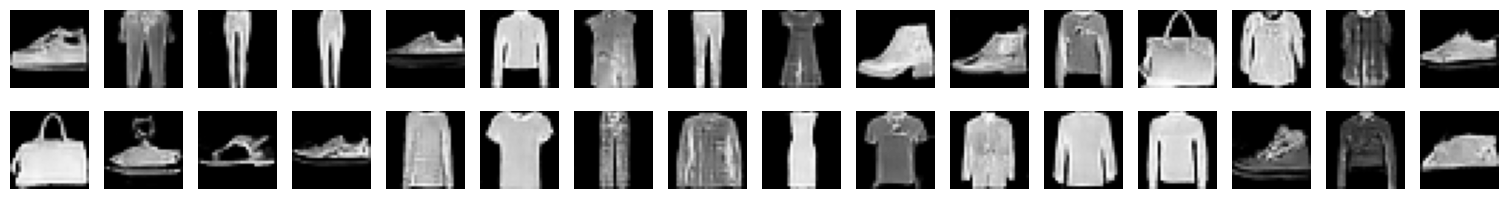

[211/250][150/235]	Loss_D: 0.2273	Loss_G: 5.1617	D(x): 0.9727	D(G(z)): 0.1397 / 0.0135
[212/250][150/235]	Loss_D: 0.1271	Loss_G: 3.9777	D(x): 0.9171	D(G(z)): 0.0334 / 0.0412
[213/250][150/235]	Loss_D: 0.1537	Loss_G: 4.1007	D(x): 0.9378	D(G(z)): 0.0725 / 0.0398
[214/250][150/235]	Loss_D: 0.1087	Loss_G: 4.1152	D(x): 0.9537	D(G(z)): 0.0549 / 0.0347
[215/250][150/235]	Loss_D: 0.2486	Loss_G: 4.1204	D(x): 0.8790	D(G(z)): 0.0832 / 0.0420


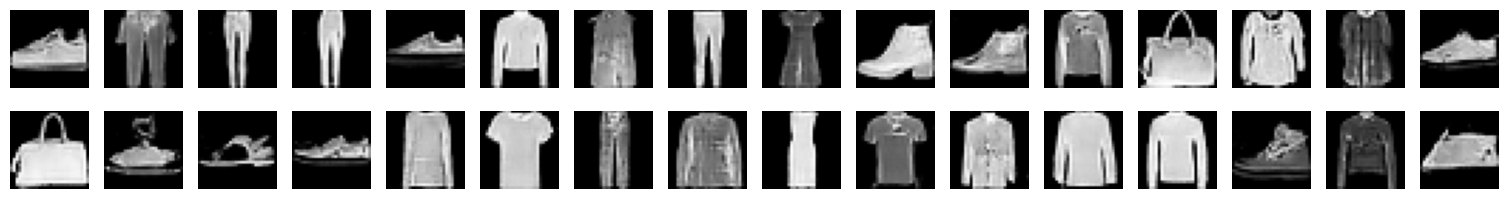

[216/250][150/235]	Loss_D: 0.2192	Loss_G: 2.7959	D(x): 0.8912	D(G(z)): 0.0760 / 0.1206
[217/250][150/235]	Loss_D: 0.1982	Loss_G: 4.6994	D(x): 0.9409	D(G(z)): 0.1029 / 0.0204
[218/250][150/235]	Loss_D: 0.1123	Loss_G: 4.3199	D(x): 0.9524	D(G(z)): 0.0563 / 0.0313
[219/250][150/235]	Loss_D: 0.2530	Loss_G: 2.8237	D(x): 0.8226	D(G(z)): 0.0275 / 0.1248
[220/250][150/235]	Loss_D: 0.4162	Loss_G: 5.5370	D(x): 0.9811	D(G(z)): 0.2424 / 0.0118


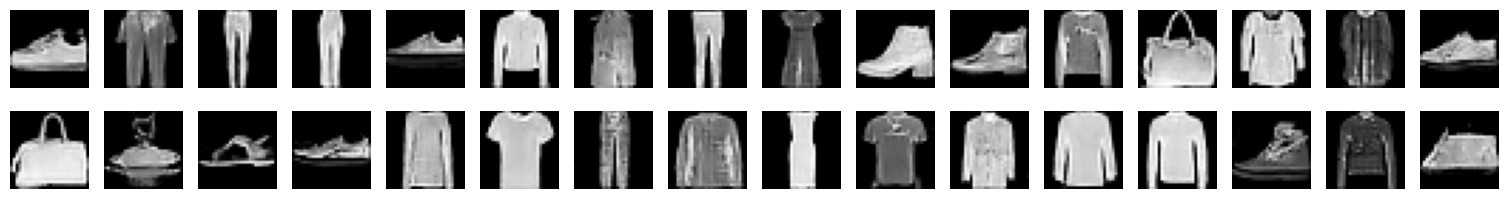

[221/250][150/235]	Loss_D: 0.1911	Loss_G: 4.1374	D(x): 0.9598	D(G(z)): 0.1131 / 0.0326
[222/250][150/235]	Loss_D: 0.1356	Loss_G: 3.8729	D(x): 0.9716	D(G(z)): 0.0895 / 0.0440
[223/250][150/235]	Loss_D: 0.1069	Loss_G: 4.1607	D(x): 0.9512	D(G(z)): 0.0489 / 0.0377
[224/250][150/235]	Loss_D: 0.0888	Loss_G: 4.1777	D(x): 0.9600	D(G(z)): 0.0434 / 0.0346
[225/250][150/235]	Loss_D: 0.1672	Loss_G: 3.6019	D(x): 0.8880	D(G(z)): 0.0382 / 0.0629


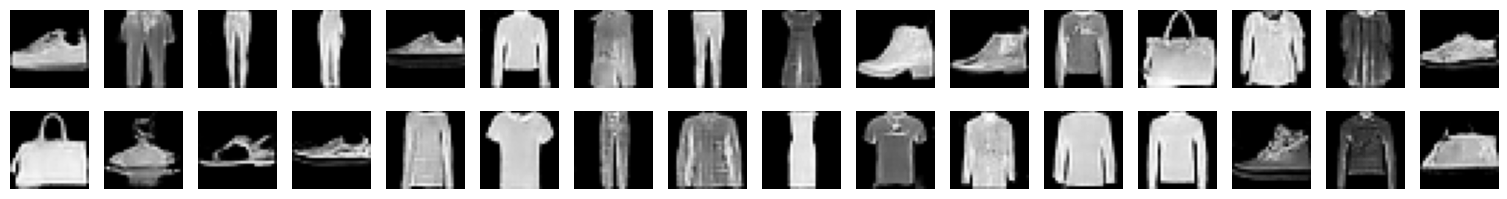

[226/250][150/235]	Loss_D: 0.1027	Loss_G: 4.2805	D(x): 0.9586	D(G(z)): 0.0504 / 0.0379
[227/250][150/235]	Loss_D: 0.1358	Loss_G: 4.3994	D(x): 0.9760	D(G(z)): 0.0832 / 0.0321
[228/250][150/235]	Loss_D: 0.2720	Loss_G: 3.7317	D(x): 0.8683	D(G(z)): 0.0955 / 0.0573
[229/250][150/235]	Loss_D: 0.3854	Loss_G: 1.8093	D(x): 0.7427	D(G(z)): 0.0396 / 0.2929
[230/250][150/235]	Loss_D: 0.1424	Loss_G: 4.2979	D(x): 0.9814	D(G(z)): 0.1000 / 0.0300


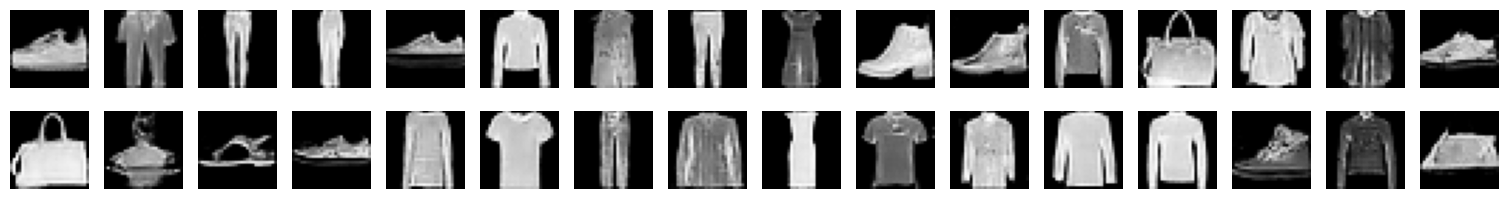

[231/250][150/235]	Loss_D: 0.1248	Loss_G: 4.5399	D(x): 0.9379	D(G(z)): 0.0488 / 0.0284
[232/250][150/235]	Loss_D: 0.9205	Loss_G: 2.5510	D(x): 0.7167	D(G(z)): 0.2147 / 0.2567
[233/250][150/235]	Loss_D: 0.2909	Loss_G: 3.6307	D(x): 0.9499	D(G(z)): 0.1787 / 0.0644
[234/250][150/235]	Loss_D: 0.3138	Loss_G: 2.8395	D(x): 0.7800	D(G(z)): 0.0284 / 0.1387
[235/250][150/235]	Loss_D: 0.3195	Loss_G: 3.2394	D(x): 0.8709	D(G(z)): 0.1293 / 0.0954


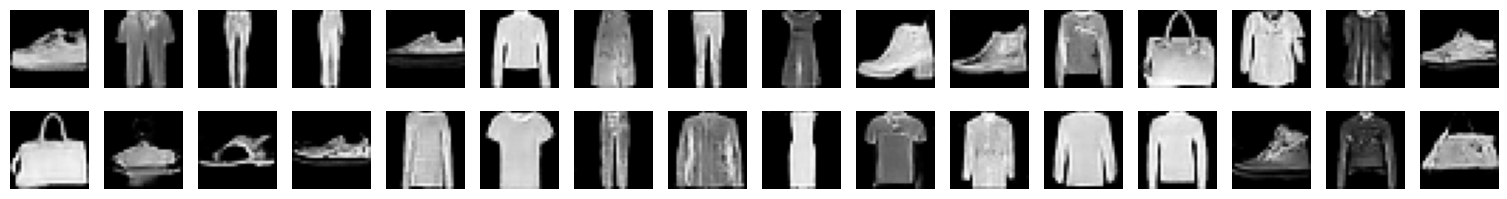

[236/250][150/235]	Loss_D: 0.1306	Loss_G: 3.8034	D(x): 0.9290	D(G(z)): 0.0448 / 0.0535
[237/250][150/235]	Loss_D: 0.1294	Loss_G: 4.5371	D(x): 0.9781	D(G(z)): 0.0909 / 0.0242
[238/250][150/235]	Loss_D: 0.1362	Loss_G: 3.9392	D(x): 0.9376	D(G(z)): 0.0621 / 0.0397
[239/250][150/235]	Loss_D: 0.1447	Loss_G: 4.4890	D(x): 0.9143	D(G(z)): 0.0417 / 0.0320
[240/250][150/235]	Loss_D: 0.0931	Loss_G: 3.7666	D(x): 0.9469	D(G(z)): 0.0343 / 0.0546


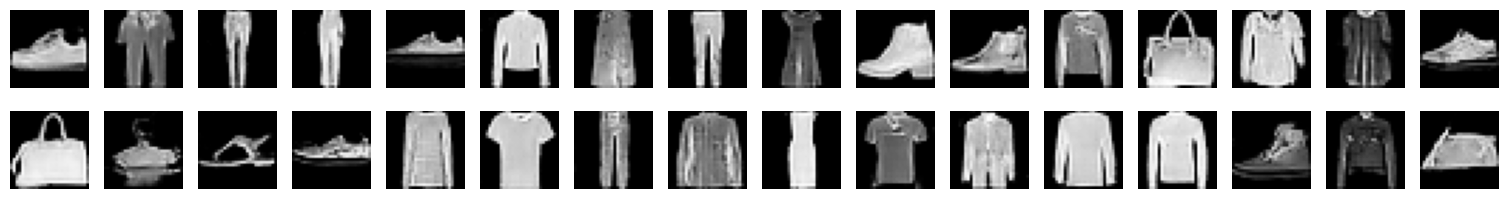

[241/250][150/235]	Loss_D: 0.0694	Loss_G: 4.4590	D(x): 0.9741	D(G(z)): 0.0396 / 0.0260
[242/250][150/235]	Loss_D: 0.1448	Loss_G: 5.1630	D(x): 0.8803	D(G(z)): 0.0062 / 0.0167
[243/250][150/235]	Loss_D: 0.4155	Loss_G: 3.8452	D(x): 0.7229	D(G(z)): 0.0058 / 0.0670
[244/250][150/235]	Loss_D: 0.1096	Loss_G: 4.4810	D(x): 0.9220	D(G(z)): 0.0191 / 0.0299
[245/250][150/235]	Loss_D: 0.0862	Loss_G: 4.2219	D(x): 0.9473	D(G(z)): 0.0277 / 0.0342


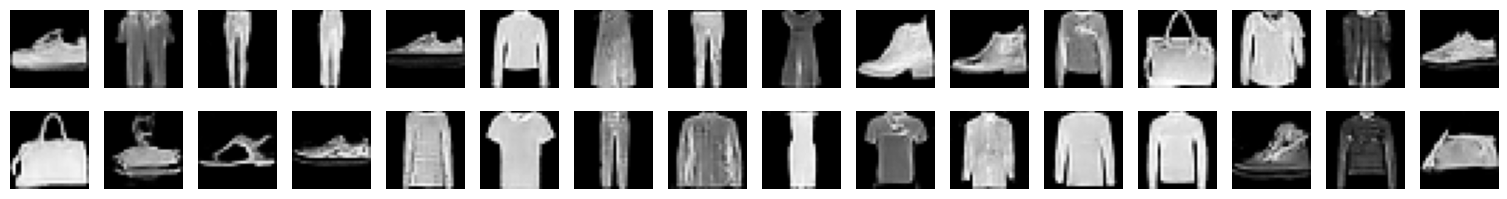

[246/250][150/235]	Loss_D: 1.7415	Loss_G: 0.9976	D(x): 0.3151	D(G(z)): 0.0384 / 0.5119
[247/250][150/235]	Loss_D: 0.2530	Loss_G: 3.7538	D(x): 0.8237	D(G(z)): 0.0255 / 0.0667
[248/250][150/235]	Loss_D: 0.1232	Loss_G: 3.9416	D(x): 0.9401	D(G(z)): 0.0481 / 0.0444
[249/250][150/235]	Loss_D: 0.0823	Loss_G: 4.2815	D(x): 0.9490	D(G(z)): 0.0262 / 0.0297
[250/250][150/235]	Loss_D: 0.1306	Loss_G: 3.5648	D(x): 0.9223	D(G(z)): 0.0417 / 0.0714


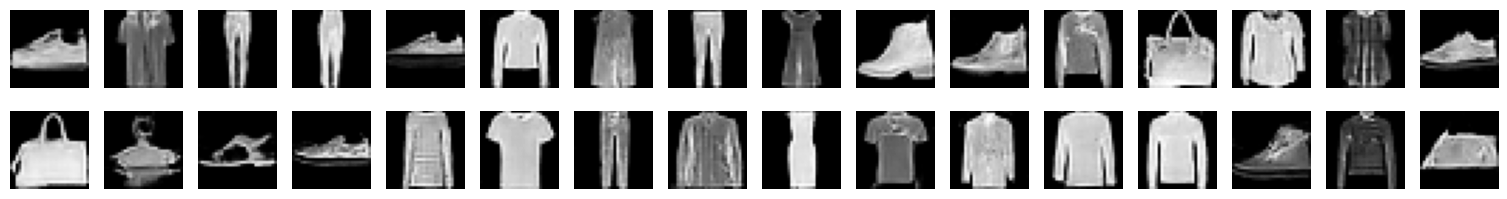

In [9]:
Utils.GAN_train(netD, netG, optimizerD, optimizerG, criterion, dataloader,
                EPOCH_NUM, X_DIM, LATENT_DIM, viz_noise, device)

## Sample fake images

fake images


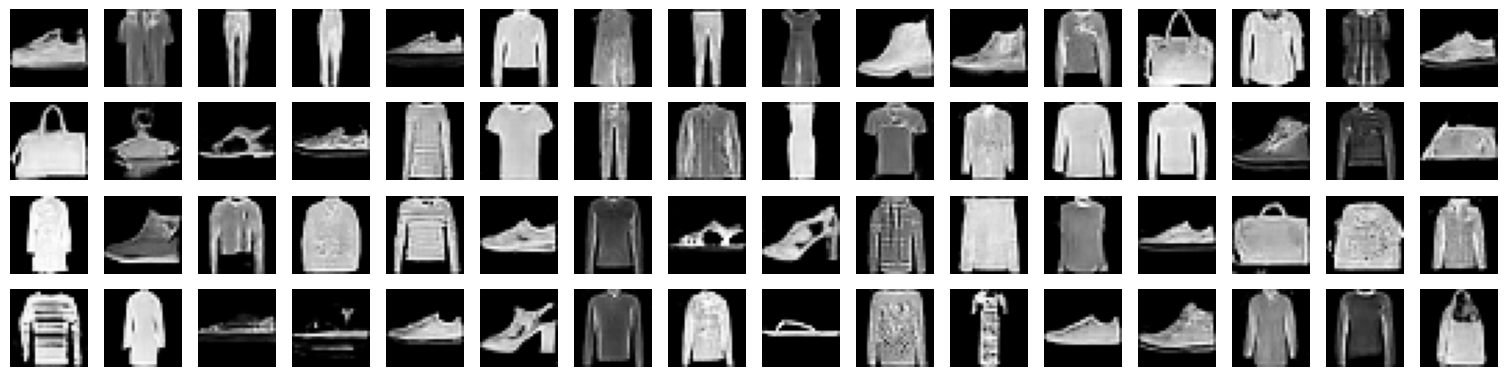

In [10]:
Utils.gan_plot_fake(netG, viz_noise, X_DIM, cnt=64)

## Saving the model

In [12]:
model = nn.Sequential(netG, nn.Upsample(size=56, mode='nearest'))  # Upsampling the images to 56x56
dummy_input = torch.randn(1, LATENT_DIM, 1, 1).to(device)
Utils.save_model(model, dummy_input, 'GAN_Fashion_MNIST')